In [5]:
import os
import argparse
import os
import torch
from exp.exp_main import Exp_Main
import random
import numpy as np
from utils.tools import dotdict
import pandas as pd
import matplotlib.pyplot as plt
from data_provider.data_factory import data_provider

import os
import datetime
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

from tqdm.notebook import tqdm

In [7]:
args = dotdict()
args.target = 'e_mu_current'
args.des = 'test'
args.dropout = 0.05
args.num_workers = 10
args.gpu = 0
args.lradj = 'type1'
args.devices = '0'
args.use_gpu = True
args.use_multi_gpu = False

args.freq = 'h'
args.checkpoints = './checkpoints/'
args.bucket_size = 4
args.n_hashes = 4
args.is_trainging = True
args.root_path = './datasets/'
args.data_path ='data_step=60_train=0.9.csv'
args.model_id='qber_96_48'
args.model = 'Autoformer'
args.data = 'custom'
args.features = 'MS'
args.seq_len = 96
args.label_len = 48
args.pred_len = 1
args.e_layers = 6
args.d_layers = 6
args.n_heads = 8
args.factor = 3
args.enc_in = 6
args.dec_in =6
args.c_out = 6
args.d_model = 512
args.des = 'Exp'
args.itr = 1
args.d_ff = 2048
args.moving_avg = 25
args.factor = 1
args.distil = False
args.output_attention = True
args.patience= 3
args.learning_rate = 0.0001
args.batch_size = 64
args.embed = 'timeF'
args.activation = 'gelu'
args.use_amp = False
args.loss = 'mse'
args.train_epochs = 5

exp = Exp_Main(args)

Use GPU: cuda:0


In [8]:
setting='qber_96_48_Autoformer_custom_ftMS_sl96_ll48_pl1_dm512_nh8_el6_dl6_df2048_fc1_ebtimeF_dtFalse_Exp_0'
best_model_path=f'./checkpoints/{setting}/checkpoint.pth'

exp.model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [13]:
dataset, pred_loader=data_provider(args, flag='test')


test 33273


In [0]:
exp.model.eval()

preds = []
trues = []

with torch.no_grad():
    for i, (batch_x, batch_y, batch_x_mark, batch_y_mark) in enumerate(pred_loader):
        batch_x = batch_x.float().to(exp.device)
        batch_y = batch_y.float().to(exp.device)

        batch_x_mark = batch_x_mark.float().to(exp.device)
        batch_y_mark = batch_y_mark.float().to(exp.device)

        outputs, batch_y = exp._predict(batch_x, batch_y, batch_x_mark, batch_y_mark)

        outputs = outputs.detach().cpu().numpy()
        batch_y = batch_y.detach().cpu().numpy()

        pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
        true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()

        preds.append(pred)
        trues.append(true)
        print(i)


In [15]:

preds = np.concatenate(preds, axis=0)
trues = np.concatenate(trues, axis=0)

In [30]:
prediction=exp.predict(setting,pred_loader, True)

2023-09-06:19:03:52,267 INFO     [exp_main.py:248] ./checkpoints/qber_96_48_Autoformer_custom_ftMS_sl96_ll48_pl1_dm512_nh8_el6_dl6_df2048_fc1_ebtimeF_dtFalse_Exp_0/checkpoint.pth


In [17]:
preds.shape

(13184, 1, 1)

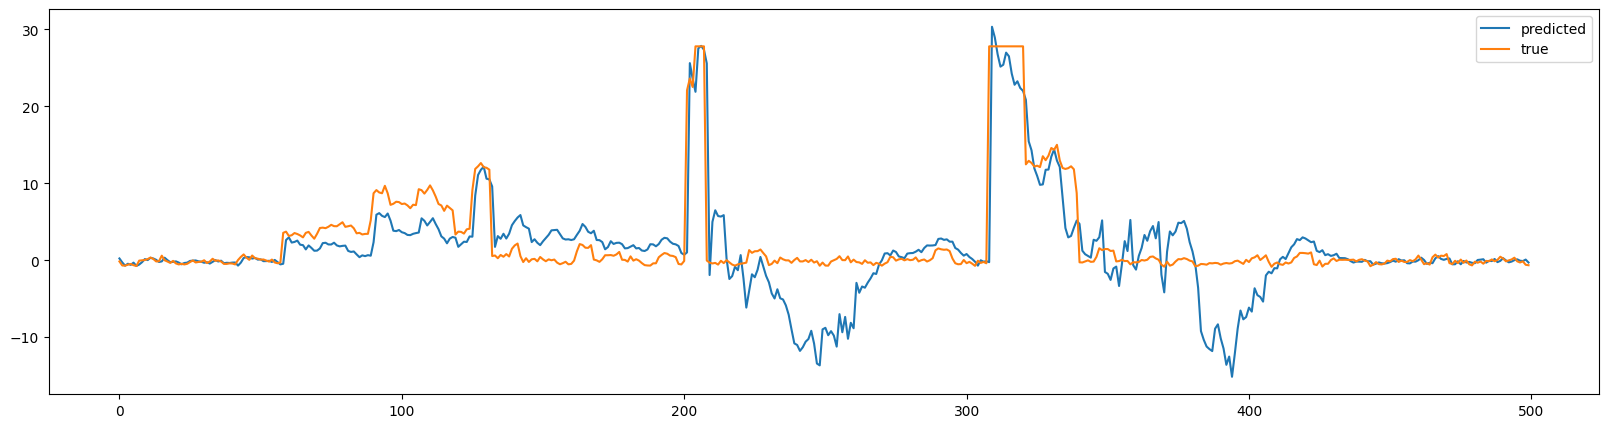

In [19]:
start=8200
end=8700
plt.figure(figsize=(20,5))
plt.plot(preds[start:end,0,0])
plt.plot(trues[start:end,0,0])
plt.legend(['predicted','true'])
plt.show()

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data_true[0:1000,0,0])